# Example: NXWriter callback

**Objective**

Demonstrate use of `apstools.callbacks.NXWriter` with [Bluesky](https://blueskyproject.io/bluesky) data acquisition and then use export data from [databroker](https://blueskyproject.io/databroker).  The `NXWriter` records data from a Bluesky measurement [run](https://blueskyproject.io/bluesky/multi_run_plans.html#definition-of-a-run) in a [NeXus](https://manual.nexusformat.org/user_manual.html) [HDF5](https://www.hdfgroup.org/solutions/hdf5) data file.

**Contents**

- [Use as callback](#Callback)
- [Export data to HDF5 file](#Export)

## Use as callback

To demonstrate how the `NXWriter` is used as a callback, it is necessary to have a data acquisition setup.

This example scans a `sensor` in response to a `motor` position.  The `NXWriter` is subscribed to the `RunEngine` so that during data collection, the `NXWriter` receives data updates.  Once the acquisition ends (when a `stop` document is received), the HDF5 file is written.

The data acquisition is a prebuilt [synApps xxx IOC](https://github.com/epics-modules/xxx) driver, packaged in a [docker](https://www.docker.com/) image
([prjemian/custom-synapps-6.2](https://hub.docker.com/r/prjemian/custom-synapps-6.2/tags)).  The [EPICS IOC](https://docs.epics-controls.org/projects/how-tos/en/latest/getting-started/creating-ioc.html) is configured with prefix `gp:` using the [bash shell script](https://github.com/prjemian/epics-docker/blob/main/v1.1/n5_custom_synApps/start_xxx.sh):

```bash
start_xxx.sh gp
```

For the purposes of demonstration, the sensor is a random number generator (new values at 10 Hz).  The random number generator is provided by a [userCalc](https://htmlpreview.github.io/?https://raw.githubusercontent.com/epics-modules/calc/R3-6-1/documentation/swaitRecord.html).  The motor is a [software simulator of a stepping motor](https://github.com/epics-motor/motorMotorSim).  There is no particular correlation between the `sensor` and the `motor` in this example, they used only for purposes of illustration.

After connecting with the EPICS PVs, the `RunEngine` is constructed and connected with a temporary databroker catalog.

In [1]:
%matplotlib inline
from apstools.synApps import setup_random_number_swait
from apstools.synApps import SwaitRecord
from bluesky import RunEngine
from bluesky import SupplementalData
from bluesky import plans as bp
from bluesky.callbacks.best_effort import BestEffortCallback
from matplotlib import pyplot as plt
from ophyd import EpicsMotor
from ophyd import EpicsSignalRO
import databroker

IOC = "gp:"

# ophyd-level
motor = EpicsMotor(f"{IOC}m10", name="motor")
calc10 = SwaitRecord(f"{IOC}userCalc10", name="calc10")
sensor = EpicsSignalRO(calc10.calculated_value.pvname, name="sensor")
calc10.wait_for_connection()
motor.wait_for_connection()
sensor.wait_for_connection()
setup_random_number_swait(calc10)

# bluesky-level
best_effort_callback = BestEffortCallback()
cat = databroker.temp().v2
plt.ion()  # enables matplotlib graphics
RE = RunEngine({})
RE.subscribe(cat.v1.insert)
RE.subscribe(best_effort_callback)  # LivePlot & LiveTable


1

Setup the `NXWriter` to create and write the scan data to an HDF5 file.  We override the default HDF5 file name.  The steps:

1. import the Python structures
2. Define the file name.  (A pathlib object provides an easy way to test if the
   file exists.)
3. Create the `NXWriter` instance
4. Subscribe the writer's `receiver` to the RunEngine.
5. Configure the writer for file name and to suppress extra warnings in the example.

In [2]:
from apstools.callbacks import NXWriter
import pathlib

h5_file = pathlib.Path("/tmp/nxwriter.h5")

nxwriter = NXWriter()
RE.subscribe(nxwriter.receiver)
nxwriter.file_name = str(h5_file)
nxwriter.warn_on_missing_content = False

Collect data by scanning `sensor` *v*. ` motor`.  A `LiveTable` and ` LivePlot` will be shown.

The `sensor` updates automatically at 10 Hz.  The `motor` moves slowly enough that the sensor updates before the next position is reached.  The data itself is for the purpose of demonstrating the `NXWriter` callback.

After the scan, show that the file exists.



Transient Scan ID: 1     Time: 2022-08-12 17:15:49
Persistent Unique Scan ID: '50d9c254-6725-4e1d-8624-18e319afc027'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |     sensor |
+-----------+------------+------------+------------+
|         1 | 17:15:50.5 |   -0.50000 |    0.30529 |
|         2 | 17:15:51.0 |   -0.25000 |    0.49244 |
|         3 | 17:15:51.5 |    0.00000 |    0.47031 |
|         4 | 17:15:52.0 |    0.25000 |    0.52802 |
|         5 | 17:15:52.5 |    0.50000 |    0.95268 |
+-----------+------------+------------+------------+
generator scan ['50d9c254'] (scan num: 1)



h5_file.exists()=True  h5_file=PosixPath('/tmp/nxwriter.h5')


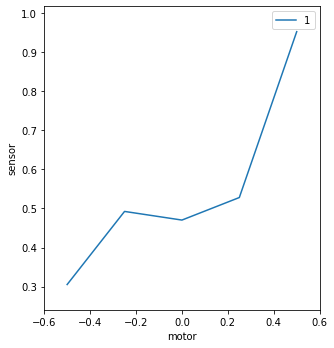

In [3]:
RE(bp.scan([sensor], motor, -0.5, 0.5, 5))
print(f"{h5_file.exists()=}  {h5_file=}")

Show the content of the NeXus HDF5 data file using [punx](https://punx.readthedocs.io), a program external to our Bluesky Python session.

In [4]:
from apstools.utils import unix

for line in unix(f"punx tree {nxwriter.file_name}"):
    print(line.decode().strip())

!!! WARNING: this program is not ready for distribution.

/tmp/nxwriter.h5 : NeXus data file
  @HDF5_Version = "1.12.1"
  @NeXus_version = "v2020.1"
  @creator = "NXWriter"
  @default = "entry"
  @file_name = "/tmp/nxwriter.h5"
  @file_time = "2022-08-12T17:15:52.718749"
  @h5py_version = "3.7.0"
  entry:NXentry
    @NX_class = "NXentry"
    @default = "data"
    @target = "/entry"
    duration:NX_FLOAT64[] = 
      @units = "s"
    end_time:NX_CHAR = b'2022-08-12T17:15:52.566333'
    entry_identifier --> /entry/instrument/bluesky/metadata/run_start_uid
    plan_name --> /entry/instrument/bluesky/metadata/plan_name
    program_name:NX_CHAR = b'bluesky'
    start_time:NX_CHAR = b'2022-08-12T17:15:49.194144'
    title:NX_CHAR = b'scan-S0001-50d9c25'
    data:NXdata
      @NX_class = "NXdata"
      @axes = ["motor"]
      @signal = "sensor"
      @target = "/entry/data"
      EPOCH --> /entry/instrument/bluesky/streams/primary/sensor/time
      motor --> /entry/instrument/bluesky/streams/

## Export

It is possible to use the `NXWriter` to export the data from the databroker to a NeXus/HDF5 file.  The bluesky community is preparing the [tiled](https://blueskyproject.io/tiled/) data access service to make such data readily available.

This example shows an alternative method to export one *run* to one NeXus/HDF5 data file.  While other variations are possible (such as a list of runs in one file), they are not shown here to keep the example simple.

The data export is based on the [replay()](https://bcda-aps.github.io/apstools/api/_utils.html?highlight=replay#apstools.utils.misc.replay) from [apstools](https://bcda-aps.github.io/apstools).

We assume the *run* to be exported is identified by `scan_id = 1`, as the example above shows.  This example uses the `cat` object created above.  You should create this as shown in the comment.

The steps:

1. the Python imports
2. define the file to be read and the scan_id
3. create the `NXWriter()` instance
4. suppress the warnings we do not need to see
5. use `replay()` to get the data (note the `v1` is important) and send it to
   the `receiver`
6. show the new HDF5 file exists

In [5]:
from apstools.callbacks import NXWriter
from apstools.utils import replay
import databroker

# This example uses 'cat' as defined above.  You use this next line:
# cat = databroker.databroker["YOUR_CATALOG_NAME"]

h5_file = pathlib.Path("/tmp/db_export.h5")
scan_id = 1  # TODO: you choose

nxwriter = NXWriter()
nxwriter.file_name = str(h5_file)
nxwriter.warn_on_missing_content = False
replay(cat.v1[scan_id], nxwriter.receiver)
print(f"{h5_file.exists()=}  {h5_file=}")

h5_file.exists()=True  h5_file=PosixPath('/tmp/db_export.h5')
